# **Sameer Shaik - G49843839**

# Support Vector Machines

Support vector machines (SVMs) are a flexible class of supervised algorithms for both classification and regression. As we discussed in class there are an infinite number of linear discriminative classifiers that could separate two sets of data, and thereby create a model for classification.
Such as for the two-dimensional data like that shown here below:

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


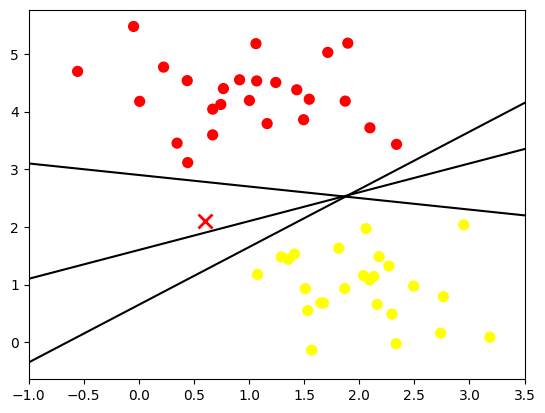

In [4]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

These are three *very* different separators which, nevertheless, perfectly discriminate between these samples.
Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label!
Evidently our simple intuition of "drawing a line between classes" is not good enough, and we need to think a bit more deeply.

## Support Vector Machines: Maximizing the Margin

Support vector machines offer one way to improve on this.
The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a *margin* of some width, up to the nearest point.
Here is an example of how this might look (see the following figure):

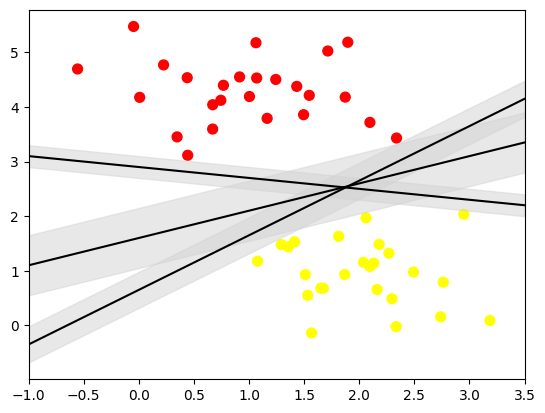

In [5]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='lightgray', alpha=0.5)

plt.xlim(-1, 3.5);

The line that maximizes this margin is the one we will choose as the optimal model.

### Fitting a Support Vector Machine

Let's see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier (`SVC`) to train an SVM model on this data.
For the time being, we will use a linear kernel and set the ``C`` parameter to a very large number (we'll discuss the meaning of these in more depth momentarily):

In [6]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us (see the following figure):

In [7]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, edgecolors='black',
                   facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

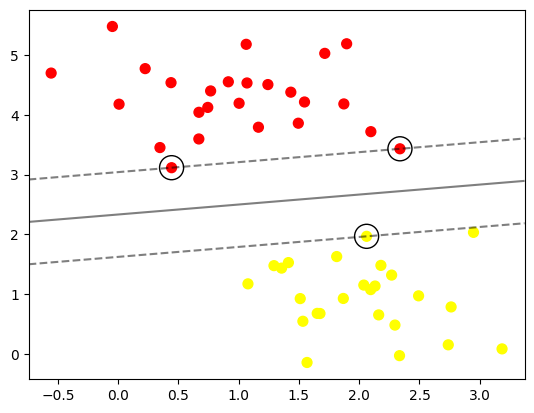

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

This is the dividing line that maximizes the margin between the two sets of points.
Notice that a few of the training points just touch the margin: they are circled in the following figure.
These points are the pivotal elements of this fit; they are known as the *support vectors*, and give the algorithm its name.
In Scikit-Learn, the identities of these points are stored in the `support_vectors_` attribute of the classifier:

In [ ]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

A key to this classifier's success is that for the fit, only the positions of the support vectors matter; any points further from the margin that are on the correct side do not modify the fit.
Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

We can see this, for example, if we plot the model learned from the first 60 points and first 120 points of this dataset (see the following figure):

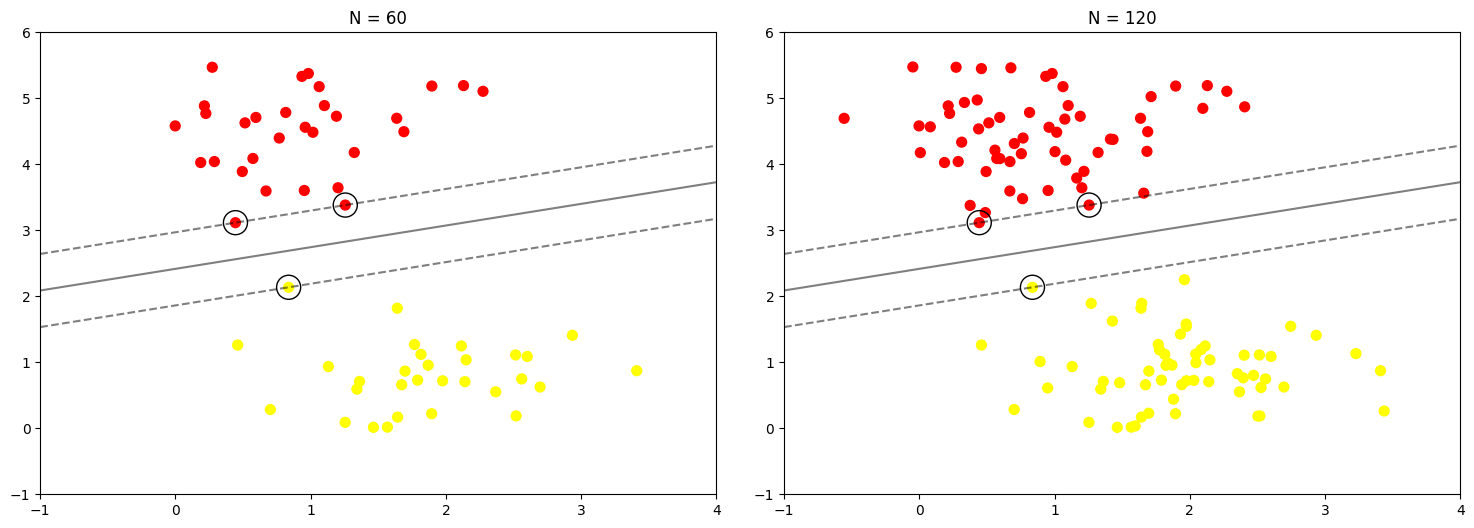

In [8]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)

    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

In the left panel, we see the model and the support vectors for 60 training points.
In the right panel, we have doubled the number of training points, but the model has not changed: the three support vectors in the left panel are the same as the support vectors in the right panel.
This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

### Beyond Linear Boundaries: Kernel SVM

Where SVM can become quite powerful is when it is combined with *kernels*. To motivate the need for kernels, let's look at some data that is not linearly separable (see the following figure):

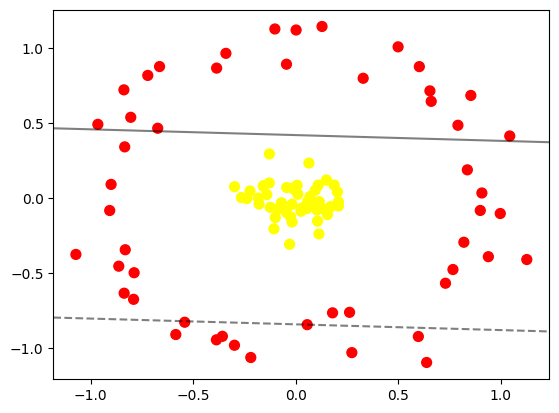

In [ ]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

It is clear that no linear discrimination will *ever* be able to separate this data.  However, one simple projection we could use would be to compute a *radial basis function* (RBF) centered on the middle clump:

In [ ]:
r = np.exp(-(X ** 2).sum(1))

We can visualize this extra data dimension using a three-dimensional plot, as seen in the following figure:

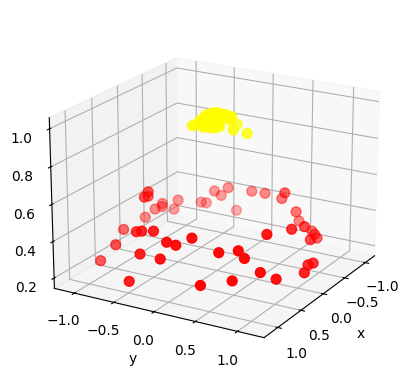

In [ ]:
from mpl_toolkits import mplot3d

ax = plt.subplot(projection='3d')
ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
ax.view_init(elev=20, azim=30)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('r');

We can see that with this additional dimension, the data becomes trivially linearly separable, by drawing a separating plane at, say, *r*=0.7.

In this case we had to choose and carefully tune our projection: if we had not centered our radial basis function in the right location, we would not have seen such clean, linearly separable results.
In general, the need to make such a choice is a problem: we would like to somehow automatically find the best basis functions to use.

One strategy to this end is to compute a basis function centered at *every* point in the dataset, and let the SVM algorithm sift through the results.
This type of basis function transformation is known as a *kernel transformation*, as it is based on a similarity relationship (or kernel) between each pair of points.

A potential problem with this strategy—projecting $N$ points into $N$ dimensions—is that it might become very computationally intensive as $N$ grows large.
However, because of a neat little procedure known as the [*kernel trick*](https://en.wikipedia.org/wiki/Kernel_trick), a fit on kernel-transformed data can be done implicitly—that is, without ever building the full $N$-dimensional representation of the kernel projection.
This kernel trick is built into the SVM, and is one of the reasons the method is so powerful.

In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to an RBF kernel, using the `kernel` model hyperparameter:

In [ ]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0)

Let's use our previously defined function to visualize the fit and identify the support vectors (see the following figure):

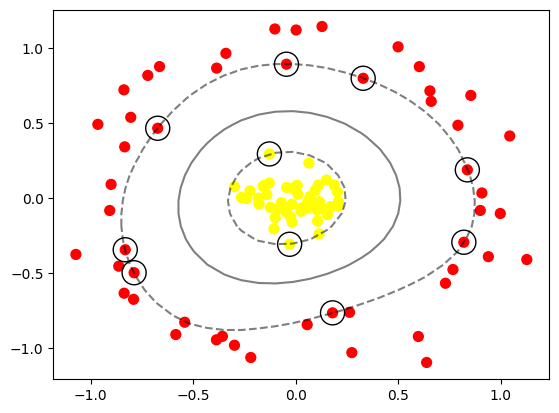

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

Using this kernelized support vector machine, we learn a suitable nonlinear decision boundary.
This kernel transformation strategy is used often in machine learning to turn fast linear methods into fast nonlinear methods, especially for models in which the kernel trick can be used.

### Tuning the SVM: Softening Margins

Our discussion thus far has centered around very clean datasets, in which a perfect decision boundary exists.
But what if your data has some amount of overlap?
For example, you may have data like this (see the following figure):

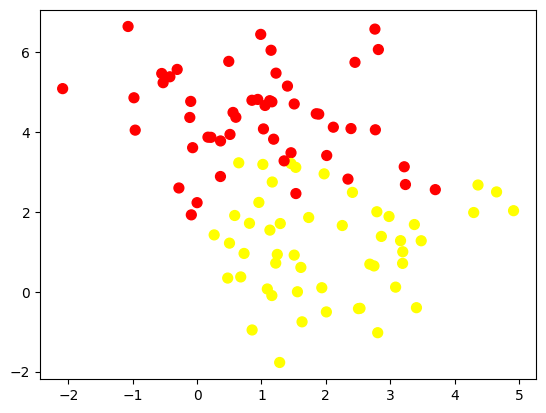

In [ ]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

To handle this case, the SVM implementation has a bit of a fudge factor that "softens" the margin: that is, it allows some of the points to creep into the margin if that allows a better fit.
The hardness of the margin is controlled by a tuning parameter, most often known as `C`.
For a very large `C`, the margin is hard, and points cannot lie in it.
For a smaller `C`, the margin is softer and can grow to encompass some points.

The plot shown in the following figure gives a visual picture of how a changing `C` affects the final fit via the softening of the margin:

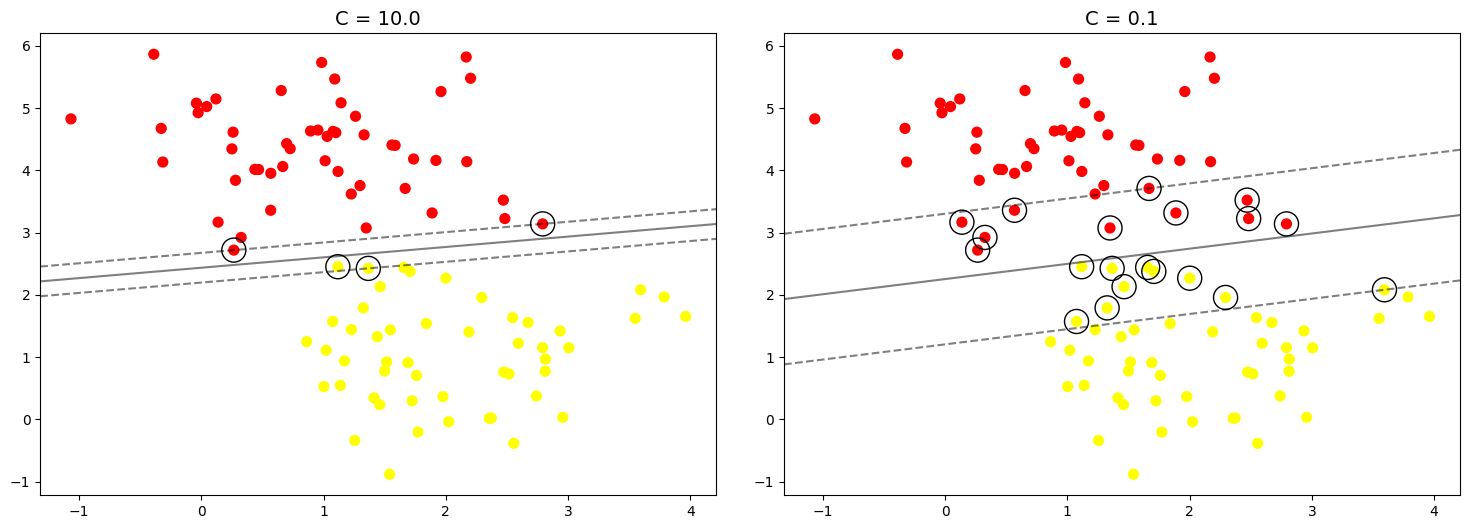

In [ ]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

The optimal value of `C` will depend on your dataset, and you should tune this parameter using cross-validation or a similar procedure.

## Application of SVM

Fashion MNIST is a dataset developed by Zalando, an online fashion retailer, as a more challenging alternative to the original MNIST dataset which consists of handwritten digits. Fashion MNIST comprises 70,000 grayscale images across 10 different categories of fashion items. These categories include T-shirts/tops, trousers, pullovers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots. Each image is 28x28 pixels, providing a standardized frame for straightforward input into machine learning models.

The primary purpose of Fashion MNIST is to serve as a benchmark for machine learning algorithms, particularly in the realm of image recognition and classification. Its creation was motivated by the need for a more difficult dataset than MNIST, which had become too easy for modern machine learning techniques, diminishing its usefulness as a benchmark.

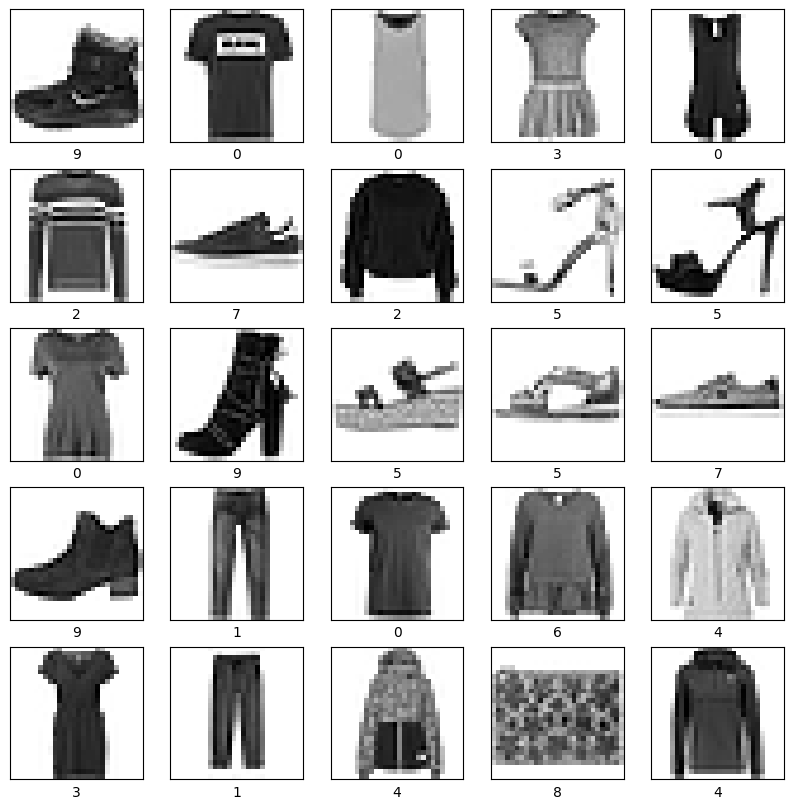

In [ ]:
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt

# Load Fashion MNIST dataset
fashion_mnist = fetch_openml(name='Fashion-MNIST', version=1)

# The data key contains the images, and the target key contains the labels
images, labels = fashion_mnist.data, fashion_mnist.target

# Convert images from flat (1D) arrays to 2D arrays (28x28 pixels)
images = np.array(images).reshape(-1, 28, 28).astype('float32')

# Normalize the images to have values between 0 and 1
images /= 255.0

# Convert labels to integers
labels = labels.astype('int64')

# Plot the first 25 images from the dataset
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.binary)
    plt.xlabel(labels[i])
plt.show()

**Exercise 4-1:** SVM Classifier for Fashion MNIST

In this exercise, you will develop a machine learning model using a Support Vector Machine (SVM) to classify images from the Fashion MNIST dataset. This will involve several steps, from loading and preprocessing the data to training and evaluating your SVM model. The goal is to provide practical experience with SVM for image classification tasks.

### Overview

SVMs require input data in a specific format and are not inherently designed for multiclass classification. Scikit-learn addresses this by employing one-vs-one or one-vs-all strategies for multiclass classification. You'll need to preprocess the images by flattening them from a 2D 28x28 pixel matrix to a 1D array of 784 features, ensuring the labels are also prepared correctly for training.

### Steps and Functions to Implement

- **Data Preprocessing**
  - Flatten the images to convert them from a 2D array (28x28 pixels) to a 1D array (784 features) to fit the input requirements of SVMs.
  
    **Function to Create:**
    - `flatten_images(images)`: Converts images from a 2D array to a 1D array.

- **Model Training**
  - Train an SVM model on the preprocessed training data. Begin with a linear kernel and the default regularization parameter (C). You are encouraged to experiment with other kernels (e.g., RBF) and parameters as part of the exercise.

- **Model Evaluation**
  - Evaluate the performance of your SVM model on the test dataset. Calculate and report metrics such as accuracy, precision, recall, and F1-score to gauge the effectiveness of your model.

### Objectives

- Understand the process of preparing data for SVM classification.
- Gain experience in training and evaluating SVM models.
- Explore the impact of different kernels and hyperparameters on model performance.

In [ ]:
## YOUR CODE HERE

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# here we are Loading the Fashion-MNIST dataset
fashion_mnist = fetch_openml(name='Fashion-MNIST', version=1)
images, labels = fashion_mnist.data, fashion_mnist.target

images = np.array(images).reshape(-1, 28, 28).astype('float32')
images /= 255.0
labels = labels.astype('int64')

# then we Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

def flatten_images(images):
    return images.reshape(images.shape[0], -1)

X_train_flat, X_test_flat = flatten_images(X_train), flatten_images(X_test)

# After Spliting we Create and train the SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_flat, y_train)

# finally we Print the evaluation metrics
print("Accuracy:", accuracy_score(y_test, svm_model.predict(X_test_flat)),
      "Precision:", precision_score(y_test, svm_model.predict(X_test_flat), average='weighted'),
      "Recall:", recall_score(y_test, svm_model.predict(X_test_flat), average='weighted'),
      "F1-score:", f1_score(y_test, svm_model.predict(X_test_flat), average='weighted'))



Accuracy: 0.8562142857142857 Precision: 0.8556003850110733 Recall: 0.8562142857142857 F1-score: 0.8553041289108505


In [ ]:
# first import the SVc libraries
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# now we Create and train the Support Vector Machine
svm_model = SVC(kernel='rbf').fit(X_train_flat, y_train)

# finally we Evaluate the performance of the model on the test set and then we print the metrics
print("Accuracy:", accuracy_score(y_test, svm_model.predict(X_test_flat)),
      "Precision:", precision_score(y_test, svm_model.predict(X_test_flat), average='weighted'),
      "Recall:", recall_score(y_test, svm_model.predict(X_test_flat), average='weighted'),
      "F1-score:", f1_score(y_test, svm_model.predict(X_test_flat), average='weighted'))


Accuracy: 0.8887857142857143 Precision: 0.8881624708994528 Recall: 0.8887857142857143 F1-score: 0.8880781657700726


# Regression Decision Trees

Regression Decision Trees are specialized decision trees designed for regression tasks, where the objective is to predict a continuous outcome. Unlike classification trees that predict a class label, regression trees predict a numerical quantity.

## How Regression Decision Trees Work

1. **Splitting Criteria**: The dataset is divided based on feature values. Splits are chosen to minimize variance within each node, aiming for nodes with homogeneous target values. This ideally reduces variance and improves prediction accuracy.

2. **Tree Construction**:
   - Starting from the root node, the entire dataset is considered.
   - The best split is determined by evaluating each feature to find the split that results in the greatest reduction in variance (or sometimes mean squared error).
   - This process is recursively applied to each child node until stopping criteria are met.

3. **Stopping Criteria**:
   - To prevent overfitting, the tree's growth is controlled by criteria such as maximum depth, minimum number of samples per node, and minimum improvement in variance reduction for a split.

4. **Prediction**:
   - For a new data point, predictions are made by traversing the tree based on its feature values until reaching a leaf node.
   - The prediction is the mean target value of the samples in the leaf node.

## Advantages

- **Interpretability**: Easy to understand and interpret, making them useful in scenarios where decision-making processes need to be transparent.
- **Non-linearity**: Capable of capturing non-linear relationships without requiring data transformation.
- **Feature Interactions**: Automatically model interactions between features.

## Disadvantages

- **Overfitting**: Can grow complex and overfit the training data, capturing noise rather than the underlying pattern.
- **Variance**: Small changes in the data can result in different trees, leading to high variance. Ensemble methods like Random Forests can help reduce this.
- **Bias**: A single tree might be too simple to capture complex relationships, potentially leading to underfitting. This issue can be addressed by using deeper trees or ensemble methods.

Regression Decision Trees balance simplicity and flexibility, making them a compelling choice for regression tasks. However, their propensity for overfitting and high variance often leads to their use as components of more complex ensemble models.

In lecture, we looked at the Boston Housing data and constructed a linear regression model.  In the following exercise, we will construct a regression tree model.

In [ ]:
# first we need to import some of the libraries
import pandas as pd
from sklearn.tree import DecisionTreeRegressor,plot_tree
import numpy as np
import matplotlib.pyplot as plt


#load the BostonHousing Data file in CSV form
boston=pd.read_csv('BostonHousing.csv')

#now diplaying the plot  boston
boston

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


CRIM - per capita crime rate by town <br>
ZN - proportion of residential land zoned for lots over 25,000 sq.ft. <br>
INDUS - proportion of non-retail business acres per town. <br>
CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise) <br>
NOX - nitric oxides concentration (parts per 10 million) <br>
RM - average number of rooms per dwelling <br>
AGE - proportion of owner-occupied units built prior to 1940 <br>
DIS - weighted distances to five Boston employment centres <br>
RAD - index of accessibility to radial highways <br>
TAX - full-value property-tax rate per 10,000 <br>
PTRATIO - pupil-teacher ratio by town <br>
MEDV - Median value of owner-occupied homes in 1000's

In [ ]:
# X from the boston dataset excluding the last column
X = boston[boston.columns[:-1]]

# Y from the boston dataset speciically the Medv column
y = boston[['medv']]

**Exercise 4-2:** Construct the Regression Tree using the Boston Housing data.

Imp Feature :  rm


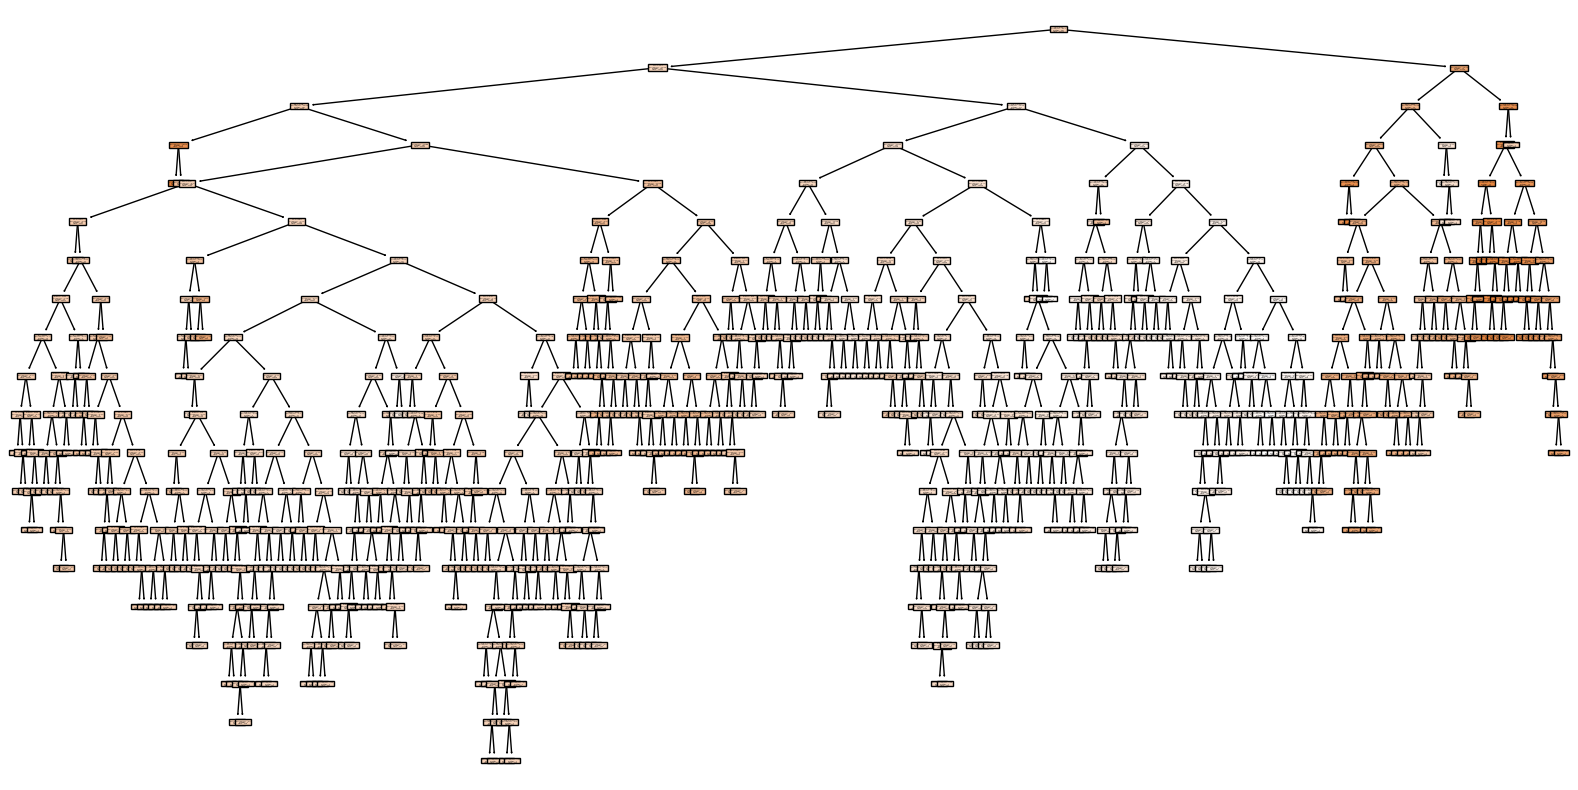

In [ ]:
## YOUR CODE HERE

# Firstly we Import the necessary libraries
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

# and then Load the Boston Housing dataset from the CSV file into a pandas DataFrame
boston_DATA = pd.read_csv('BostonHousing.csv')

# Next we Extract features (independent variables) by dropping the 'medv' column
X_F = boston_DATA.drop(columns=['medv'])

# Extract the target variable (dependent variable), which is 'medv'
y_T = boston_DATA[['medv']]

# Now we Initialize a DecisionTreeRegressor model with a random state for reproducibility
reg_TREE = DecisionTreeRegressor(random_state=42)

# Fit the DecisionTreeRegressor model using the features (X_F) and the target variable (y_T)
reg_TREE.fit(X_F, y_T)

# Identify the most important feature based on the feature importances from the DecisionTreeRegressor model
impF = X_F.columns[np.argmax(reg_TREE.feature_importances_)]

# Print the most important feature
print("Imp Feature : ", impF)

# Visualize the decision tree using the plot_tree function
plt.figure(figsize=(20, 10))
plot_tree(reg_TREE, feature_names=X_F.columns, filled=True)
plt.show()


>**Question:** Which feature was most important?

>**Answer:**

The most important feature is 'RM' which is the average number of rooms per dwelling.

## Naive Bayes Classification

**Exercise 4-3:** Given the below table, classify the test sample X = (age = youth, income = low, student = yes, credit_rating = fair).

<img src="../images/nv_bayes.jpg" alt="Drawing" style="width: 800px;"/>

>**Answer:**

In the given table, X classifies to the column "Class - buys computer" : YES

In [9]:
import pandas as pd
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import OrdinalEncoder

# Define the dataset
data = {
    'age': ['youth', 'youth', 'middle_aged', 'senior', 'senior', 'senior', 'middle_aged', 'youth', 'youth', 'senior', 'youth', 'middle_aged', 'middle_aged', 'senior'],
    'income': ['high', 'high', 'high', 'medium', 'low', 'low', 'low', 'medium', 'low', 'medium', 'medium', 'medium', 'high', 'medium'],
    'student': ['no', 'no', 'no', 'no', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'no', 'yes', 'no'],
    'credit_rating': ['fair', 'excellent', 'fair', 'fair', 'fair', 'excellent', 'excellent', 'fair', 'fair', 'fair', 'excellent', 'excellent', 'fair', 'excellent'],
    'buys_computer': ['no', 'no', 'yes', 'yes', 'yes', 'no', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'no']
}

# Create a DataFrame
df = pd.DataFrame(data)

# Initialize an OrdinalEncoder
encoder = OrdinalEncoder()

# Encode categorical features except the target
X_encoded = encoder.fit_transform(df.drop(columns=['buys_computer']))

# Target variable
y_target = df['buys_computer']

# Initialize a Categorical Naive Bayes classifier
nb_classifier = CategoricalNB()

# Fit the classifier to the data
nb_classifier.fit(X_encoded, y_target)

# Define a test sample
test_sample = pd.DataFrame({'age': ['youth'], 'income': ['low'], 'student': ['yes'], 'credit_rating': ['fair']})

# Encode the test sample
test_sample_encoded = encoder.transform(test_sample)

# Predict the class for the test sample
predicted_class = nb_classifier.predict(test_sample_encoded)

# Output the predicted class
print("\\ the predicted class for the following  test sample is -- ", predicted_class)


\ the predicted class for the following  test sample is --  ['yes']
